# **Logistic Regression (no intercept) for Predicting Article Section Based on Headlines and Abstracts**

### **DS 5110: Big Data Systems**

### **Spring 2022**

### **Group 1 - New York Times Articles Analysis**

### **Avni Malek (am7bf), Brittany Nguyen (bhn4bf), Cecily Wolfe (cew4pf)**

## **Getting the Data**

### **Set up Directory**

In [1]:
import os
os.getcwd()

'/home/cew4pf'

In [2]:
os.chdir('/project/ds5559/group1_nyt')

In [3]:
os.getcwd()

'/project/ds5559/group1_nyt'

In [4]:
# use to increase driver memory to prevent Java heap space overflow
memory = '20g'
pyspark_submit_args = ' --driver-memory ' + memory + ' pyspark-shell'
os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args

In [5]:
from pyspark.sql import SparkSession

from pyspark.sql.functions import *

spark = SparkSession.builder \
        .appName("test_11") \
        .config("spark.executor.memory", '20g') \
        .getOrCreate()

### **Read in the Preprocessed Data**

In [6]:
df = spark.read.option("header", True).csv('preprocessed_data')

In [7]:
cat_cols = [field for (field, dataType) in df.dtypes if dataType == 'string']

In [8]:
df = df.fillna("", subset = cat_cols)

## **Predict Article Section Based on Abstract Using a Logistic Regression Model**

In [9]:
# load modules

from pyspark.ml import Pipeline

from pyspark.ml.classification import LogisticRegression

from pyspark.ml.feature import VectorAssembler 

from pyspark.mllib.evaluation import MulticlassMetrics

from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import OneHotEncoder, StringIndexer, StringIndexerModel

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer

In [10]:
# load in functions that compute top k accuracy for classification and balance the data with random under/oversampling
from ds5110_proj_funcs import top_k_accuracy, balance_categories

In [11]:
# create transformers and estimator to add to pipeline

# string indexer for sections (assign number to each section)
stringIndexer = StringIndexer(inputCol = 'section', outputCol = 'sectionIndex', handleInvalid = 'skip')

# tokenize abstracts (col with list of words)
tokenizer = Tokenizer(inputCol="combo", outputCol="words")

# remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered")

# count vectorizer to return counts of words that appear in each abstract
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=100000)

# logistic regression model to predict section based on words in abstract
lr = LogisticRegression(labelCol="sectionIndex", featuresCol="features")

# pipeline
lr_pipeline = Pipeline(stages = [stringIndexer, tokenizer, remover, countVectors, lr])

In [12]:
# training, testing split

seed = 42

(train_data, test_data) = df.randomSplit([0.8, 0.2], seed = seed)

In [13]:
# create model
lr_model = lr_pipeline.fit(train_data)

In [14]:
# make predictions
lr_preds = lr_model.transform(test_data)

In [15]:
# evaluate model on test data
ev = MulticlassClassificationEvaluator(labelCol = 'sectionIndex', predictionCol="prediction")

# f1
f1 = ev.evaluate(lr_preds)

# log loss
log_loss = ev.evaluate(lr_preds, {ev.metricName: "logLoss"})

# accuracy
accuracy = ev.evaluate(lr_preds, {ev.metricName: "accuracy"})

print("f1:", f1, "\nlog_loss:", log_loss, "\naccuracy:", accuracy)

f1: 0.4788929897723756 
log_loss: 3.418212302971324 
accuracy: 0.48757575757575755


In [16]:
# training accuracy
train_lr = lr_model.transform(train_data)

ev.evaluate(train_lr, {ev.metricName: "accuracy"})

0.9999258490286222

In [17]:
# from pyspark.sql.functions import monotonically_increasing_id, array, arrays_zip, explode
from pyspark.ml.functions import vector_to_array
from pyspark.sql.window import Window

### **Top K Accuracy**

In [18]:
# compute top k = 4 accuracy for predictions (i.e., correct section in the 5 classes with the highest probability)
top_4_accuracy = top_k_accuracy(lr_preds, 'section', 4)
top_4_accuracy

0.7987878787878788

In [19]:
# compute top k = 5 accuracy for predictions (i.e., correct section in the 5 classes with the highest probability)
top_5_accuracy = top_k_accuracy(lr_preds, 'section', 5)
top_5_accuracy

0.8418181818181818

#### **Attempt with `new_section` column instead (with new "Other" label)**

In [20]:
# new StringIndexer instance using the new_section column
stringIndexer_2 = StringIndexer(inputCol = 'new_section', outputCol = 'sectionIndex')

In [21]:
lr_pipeline_2 = Pipeline(stages = [stringIndexer_2, tokenizer, remover, countVectors, lr])

In [22]:
lr_model_2 = lr_pipeline_2.fit(train_data)

In [23]:
lr_preds_2 = lr_model_2.transform(test_data)

In [24]:
# f1
f1_2 = ev.evaluate(lr_preds_2)

# log loss
log_loss_2 = ev.evaluate(lr_preds_2, {ev.metricName: "logLoss"})

# accuracy
accuracy_2 = ev.evaluate(lr_preds_2, {ev.metricName: "accuracy"})

print("f1:", f1_2, "\nlog_loss:", log_loss_2, "\naccuracy:", accuracy_2)

f1: 0.4509247660694953 
log_loss: 5.960494874872135 
accuracy: 0.45986064828839746


#### **Create A Balanced Dataset to (Potentially) Improve Accuracy $\rightarrow$ Due to Highly Imbalanced Number of Articles Per Section**

In [25]:
import numpy as np

In [26]:
# balance the data (see ds5100_proj_funcs.py for more information) --> each section sampled so ~ mean num of articles in each
balanced_data = balance_categories(df, "new_section")

In [27]:
balanced_data.groupby('new_section').count().sort('count', ascending = False).show(26)

+--------------------+-----+
|         new_section|count|
+--------------------+-----+
|             Theater|  678|
|               World|  673|
|                Arts|  669|
|        Business Day|  666|
|             Opinion|  666|
|              Health|  659|
|          Technology|  655|
|              Travel|  654|
|                U.S.|  654|
|                Food|  653|
|            Magazine|  653|
|               Style|  652|
|              Sports|  652|
|               Books|  649|
|  Crosswords & Games|  646|
|              Movies|  645|
|               Other|  642|
|            New York|  642|
|       Times Insider|  639|
|                Well|  638|
|         Real Estate|  635|
|             Climate|  634|
|             Science|  633|
|The Learning Network|  633|
|            Podcasts|  628|
|          The Upshot|  622|
+--------------------+-----+



In [28]:
# generate balanced training and testing datasets

seed = 42

(train_balanced, test_balanced) = balanced_data.randomSplit([0.8, 0.2], seed = seed)

In [29]:
lr_model_3 = lr_pipeline_2.fit(train_balanced)

In [30]:
lr_preds_3 = lr_model_3.transform(test_balanced)

In [31]:
# f1
f1_3 = ev.evaluate(lr_preds_3)

# log loss
log_loss_3 = ev.evaluate(lr_preds_3, {ev.metricName: "logLoss"})

# accuracy
accuracy_3 = ev.evaluate(lr_preds_3, {ev.metricName: "accuracy"})

print("f1:", f1_3, "\nlog_loss:", log_loss_3, "\naccuracy:", accuracy_3)

f1: 0.8023412818952628 
log_loss: 1.0572443690288384 
accuracy: 0.8048920863309352


In [32]:
# top k accuracy, k = 2
top_2_balanced = top_k_accuracy(lr_preds_3, 'section', 2)

top_2_balanced

0.858705035971223

In [33]:
# top k accuracy, k = 5
top_5_balanced = top_k_accuracy(lr_preds_3, 'section', 5)

top_5_balanced

0.920863309352518

### **Cross Validation**

In [34]:
# regenerate the balanced training and test sets without the columns with predictions and probabilites

seed = 42

(train_balanced, test_balanced) = balanced_data.randomSplit([0.8, 0.2], seed = seed)

In [35]:
# build a grid of parameters --> different vocab size for CountVectorizer, different smoothing (alpha) values for Naive Bayes
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0, 0.1, 0.01]) \
    .addGrid(lr.elasticNetParam, [0, 0.5, 1]) \
    .build()

# number of parameter combinations tested (3 x 3 = 9)
print('len(paramGrid): {}'.format(len(paramGrid)))

# CrossValidator instance with lr_pipeline as the estimator
crossval = CrossValidator(estimator=lr_pipeline_2,
                          estimatorParamMaps=paramGrid,
                          evaluator=ev,
                          numFolds=3,
                          seed = seed)

# Cross validation model that returns the best set of parameters
import time
t0 = time.time()
cvModel = crossval.setParallelism(9).fit(train_balanced)
print("train time:", time.time() - t0)

len(paramGrid): 9
train time: 1383.913274526596


In [36]:
# average metrics across three models fit for a given combination of params (since three folds)
avg_metrics = cvModel.avgMetrics

# largest metric --> default metric F1 so want to maximize
max_metric = np.max(avg_metrics)

# max metric and location in list
print("average metrics:", avg_metrics, "\n\nmin metric and position: {}, {}".format(max_metric, np.argmax(avg_metrics)))

average metrics: [0.7291373340955372, 0.7291373340955372, 0.7291373340955372, 0.7448077697600832, 0.1944755705450642, 0.04798144114027615, 0.7422039720219845, 0.7413142573903863, 0.6329445052384929] 

min metric and position: 0.7448077697600832, 3


In [37]:
ev.getMetricName()

'f1'

In [38]:
# combine average metrics and paramGrid (in same order)
metrics_and_params = list(zip(cvModel.avgMetrics, paramGrid))

# pull out best param combination (the one in cvModel)
best_params = metrics_and_params[np.argmax(avg_metrics)][1].values()
best_params

dict_values([0.1, 0.0])

In [39]:
# performance on training data
ev.evaluate(cvModel.transform(train_balanced), {ev.metricName: "accuracy"})

1.0

In [40]:
# preds on test data
predictions = cvModel.transform(test_balanced)

In [41]:
predictions.select('new_section', 'sectionIndex', 'probability', 'prediction').show()

+-----------+------------+--------------------+----------+
|new_section|sectionIndex|         probability|prediction|
+-----------+------------+--------------------+----------+
|       Well|         8.0|[0.00442581350676...|       8.0|
|       Well|         8.0|[0.00437989154572...|       8.0|
|       Well|         8.0|[0.03185257159222...|       8.0|
|       Well|         8.0|[0.00484898651471...|       8.0|
|       Well|         8.0|[0.00267092120218...|       8.0|
|       Well|         8.0|[0.01982335551061...|       8.0|
|       Well|         8.0|[0.00497530033789...|       8.0|
|       Well|         8.0|[0.00660396074789...|       8.0|
|       Well|         8.0|[0.00576025310430...|       8.0|
|       Well|         8.0|[0.03108017411675...|       5.0|
|       Well|         8.0|[0.03108017411675...|       5.0|
|       Well|         8.0|[0.00239998789106...|       8.0|
|       Well|         8.0|[0.03287894381749...|       8.0|
|       Well|         8.0|[0.00216181755673...|       8.

In [42]:
# f1
f1_crossval = ev.evaluate(predictions)

# log loss
log_loss_crossval = ev.evaluate(predictions, {ev.metricName: "logLoss"})

# accuracy
accuracy_crossval = ev.evaluate(predictions, {ev.metricName: "accuracy"})

print("f1:", f1_crossval, "\nlog_loss:", log_loss_crossval, "\naccuracy:", accuracy_crossval)

f1: 0.8184762986901735 
log_loss: 0.8190480194489154 
accuracy: 0.8166906474820144


In [43]:
# top k accuracy, k = 2
top_2_balanced = top_k_accuracy(predictions, 'section', 2)

top_2_balanced

0.8696402877697842

In [44]:
# top k accuracy, k = 5
top_5_balanced = top_k_accuracy(predictions, 'section', 5)

top_5_balanced

0.9349640287769784

### **Examine Misclassifications**

In [45]:
# dataframe that acts as a key for section and index
section_labels = predictions.select('new_section', 'sectionIndex').distinct().sort('sectionIndex')

section_labels = section_labels.withColumnRenamed('new_section', 'predicted_section') \
                               .withColumnRenamed('sectionIndex', 'label')

section_labels.show(30)

+--------------------+-----+
|   predicted_section|label|
+--------------------+-----+
|        Business Day|  0.0|
|              Travel|  1.0|
|              Health|  2.0|
|             Theater|  3.0|
|             Opinion|  4.0|
|                Arts|  5.0|
|               Other|  6.0|
|               Style|  7.0|
|                Well|  8.0|
|            Magazine|  9.0|
|              Sports| 10.0|
|               World| 11.0|
|         Real Estate| 12.0|
|          Technology| 13.0|
|                U.S.| 14.0|
|                Food| 15.0|
|       Times Insider| 16.0|
|            New York| 17.0|
|              Movies| 18.0|
|The Learning Network| 19.0|
|          The Upshot| 20.0|
|               Books| 21.0|
|            Podcasts| 22.0|
|  Crosswords & Games| 23.0|
|             Science| 24.0|
|             Climate| 25.0|
+--------------------+-----+



In [46]:
# join predictions with section_labels to get predicted section name
true_pred_sections = predictions.join(section_labels, predictions.prediction == section_labels.label) \
                                .select('new_section', 'sectionIndex', 'prediction', 'predicted_section')

true_pred_sections.show()

+-----------+------------+----------+-----------------+
|new_section|sectionIndex|prediction|predicted_section|
+-----------+------------+----------+-----------------+
|       Well|         8.0|       8.0|             Well|
|       Well|         8.0|       8.0|             Well|
|       Well|         8.0|       8.0|             Well|
|       Well|         8.0|       8.0|             Well|
|       Well|         8.0|       8.0|             Well|
|       Well|         8.0|       8.0|             Well|
|       Well|         8.0|       8.0|             Well|
|       Well|         8.0|       8.0|             Well|
|       Well|         8.0|       8.0|             Well|
|       Well|         8.0|       8.0|             Well|
|       Well|         8.0|       8.0|             Well|
|       Well|         8.0|       8.0|             Well|
|       Well|         8.0|       8.0|             Well|
|       Well|         8.0|       8.0|             Well|
|       Well|         8.0|       8.0|           

In [47]:
# filter to keep only the misclassified articles
misclassified = true_pred_sections.filter(true_pred_sections.new_section != true_pred_sections.predicted_section)

In [48]:
# most commonly misclassified sections
misclassified.groupby('new_section').count().sort('count', ascending = False).show()

+--------------------+-----+
|         new_section|count|
+--------------------+-----+
|                U.S.|   78|
|               World|   58|
|                Arts|   52|
|             Opinion|   50|
|        Business Day|   45|
|            New York|   44|
|            Magazine|   38|
|            Podcasts|   27|
|                Well|   26|
|               Style|   26|
|               Books|   21|
|         Real Estate|   20|
|          The Upshot|   19|
|               Other|   18|
|              Sports|   15|
|The Learning Network|   14|
|          Technology|   14|
|              Health|   14|
|             Theater|   13|
|             Science|   12|
+--------------------+-----+
only showing top 20 rows



In [49]:
# most common misclassification errors
misclassified.groupby(misclassified.columns).count().sort('count', ascending = False).show()

+------------+------------+----------+-----------------+-----+
| new_section|sectionIndex|prediction|predicted_section|count|
+------------+------------+----------+-----------------+-----+
|        U.S.|        14.0|       4.0|          Opinion|   19|
|Business Day|         0.0|       4.0|          Opinion|   18|
|        U.S.|        14.0|      22.0|         Podcasts|   17|
|       World|        11.0|       4.0|          Opinion|   16|
|    Podcasts|        22.0|       4.0|          Opinion|   12|
|    Magazine|         9.0|       4.0|          Opinion|   11|
|       World|        11.0|      14.0|             U.S.|   10|
|     Opinion|         4.0|      20.0|       The Upshot|   10|
|       Style|         7.0|       4.0|          Opinion|    9|
|        Arts|         5.0|       4.0|          Opinion|    9|
| Real Estate|        12.0|       4.0|          Opinion|    8|
|        Arts|         5.0|       6.0|            Other|    8|
|  The Upshot|        20.0|       4.0|          Opinion

In [50]:
# most common misclassification errors by section
misclassified.groupby(misclassified.columns).count().sort('new_section', 'count', ascending = False).show(30)

+-----------+------------+----------+--------------------+-----+
|new_section|sectionIndex|prediction|   predicted_section|count|
+-----------+------------+----------+--------------------+-----+
|      World|        11.0|       4.0|             Opinion|   16|
|      World|        11.0|      14.0|                U.S.|   10|
|      World|        11.0|       2.0|              Health|    7|
|      World|        11.0|       0.0|        Business Day|    5|
|      World|        11.0|       9.0|            Magazine|    3|
|      World|        11.0|      20.0|          The Upshot|    3|
|      World|        11.0|      22.0|            Podcasts|    3|
|      World|        11.0|      16.0|       Times Insider|    2|
|      World|        11.0|      17.0|            New York|    2|
|      World|        11.0|      15.0|                Food|    1|
|      World|        11.0|       8.0|                Well|    1|
|      World|        11.0|      13.0|          Technology|    1|
|      World|        11.0

In [51]:
# number of different sections incorrectly predicted for each section
misclassified.groupby('new_section').agg(countDistinct('predicted_section').alias('section_pred_count')) \
                                    .sort('section_pred_count', ascending = False).show()

+--------------------+------------------+
|         new_section|section_pred_count|
+--------------------+------------------+
|                Arts|                18|
|                U.S.|                17|
|            New York|                17|
|               World|                16|
|            Magazine|                16|
|             Opinion|                15|
|                Well|                13|
|               Books|                13|
|        Business Day|                11|
|              Sports|                11|
|The Learning Network|                11|
|                Food|                10|
|         Real Estate|                10|
|            Podcasts|                10|
|               Other|                10|
|               Style|                 9|
|              Health|                 8|
|          The Upshot|                 8|
|             Theater|                 8|
|          Technology|                 6|
+--------------------+------------

In [52]:
import seaborn as sns
from matplotlib import pyplot as plt

In [53]:
# number of misclassified articles by section
misclass_nums = misclassified.groupby('new_section').count().sort('count', ascending = False)

In [54]:
# number of articles in test set by section
preds_nums = predictions.groupby('new_section').count().sort('count', asceinding = False) \
                        .withColumnRenamed('new_section', 'preds_section') \
                        .withColumnRenamed('count', 'total_count')

In [55]:
# join to get misclassified and total counts for each section
misclass_percents = misclass_nums.join(preds_nums, misclass_nums.new_section == preds_nums.preds_section, "inner").drop('preds_section')

# get percentage of misclassified articles per section
misclass_percents = misclass_percents.withColumn('misclass_percent', misclass_percents['count'] / misclass_percents.total_count * 100) \
                                     .sort('misclass_percent', ascending = False)

misclass_percents.show()

+--------------------+-----+-----------+------------------+
|         new_section|count|total_count|  misclass_percent|
+--------------------+-----+-----------+------------------+
|                U.S.|   78|        139| 56.11510791366906|
|               World|   58|        155| 37.41935483870968|
|                Arts|   52|        145| 35.86206896551724|
|             Opinion|   50|        140|35.714285714285715|
|        Business Day|   45|        131| 34.35114503816794|
|            New York|   44|        131|33.587786259541986|
|            Magazine|   38|        131| 29.00763358778626|
|                Well|   26|        115|22.608695652173914|
|            Podcasts|   27|        129|20.930232558139537|
|               Style|   26|        128|           20.3125|
|         Real Estate|   20|        119| 16.80672268907563|
|          The Upshot|   19|        117| 16.23931623931624|
|               Other|   18|        118|15.254237288135593|
|               Books|   21|        145|

In [56]:
# convert to dataframe for plotting
class_nums = misclass_percents.toPandas()

class_nums

new_section  count  total_count  misclass_percent
0                   U.S.     78          139         56.115108
1                  World     58          155         37.419355
2                   Arts     52          145         35.862069
3                Opinion     50          140         35.714286
4           Business Day     45          131         34.351145
5               New York     44          131         33.587786
6               Magazine     38          131         29.007634
7                   Well     26          115         22.608696
8               Podcasts     27          129         20.930233
9                  Style     26          128         20.312500
10           Real Estate     20          119         16.806723
11            The Upshot     19          117         16.239316
12                 Other     18          118         15.254237
13                 Books     21          145         14.482759
14                Sports     15          133         11.278195
15  The Learning Network     14          128         10.937500
16                Health     14          131         10.687023
17            Technology     14          139         10.071942
18               Science     12          136          8.823529
19               Theater     13          150          8.666667
20                  Food     12          139          8.633094
21                Movies      7          135          5.185185
22                Travel      6          123          4.878049
23    Crosswords & Games      6          149          4.026846
24               Climate      2          142          1.408451

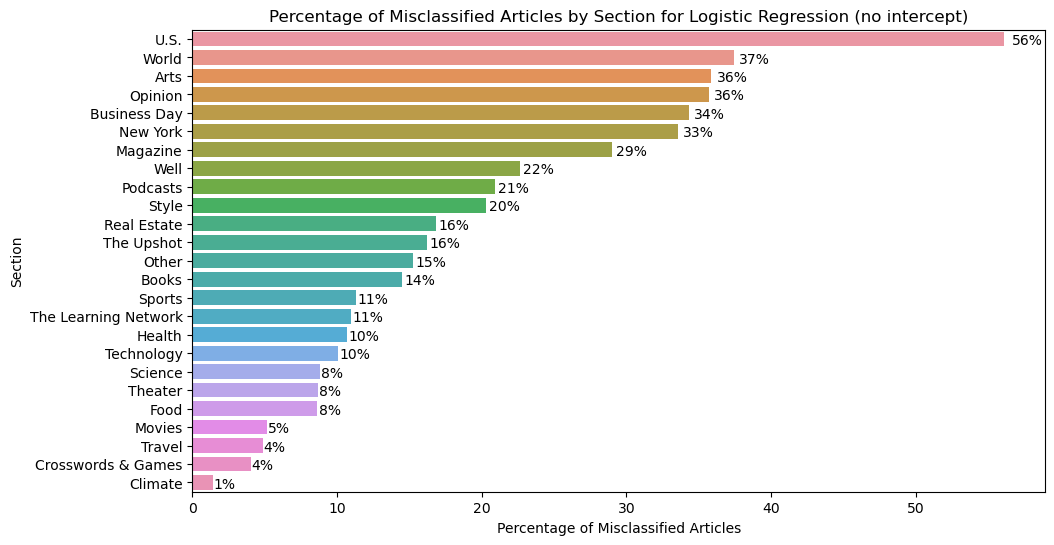

In [60]:
## code from Dr. Jonathan Kropko, University of Virginia School of Data Science; Surfing the Data Pipeline Ch. 11: Visualizations

plt.figure(figsize=(11, 6))
myplot = sns.barplot(x='misclass_percent', y='new_section', data = class_nums)
plt.ylabel('Section')
plt.xlabel('Percentage of Misclassified Articles')
plt.title('Percentage of Misclassified Articles by Section for Logistic Regression (no intercept)')
for rect in myplot.patches:
    ycoor = rect.get_y() + .6*rect.get_height()
    xcoor = 1.01*rect.get_width()
    plt.text(xcoor, ycoor, str(int(xcoor)) + "%", 
             horizontalalignment='left', 
             verticalalignment='center',
             fontsize=10)

plt.show()

plt.close()

In [58]:
misclass_groups = misclassified.groupby('new_section').agg(countDistinct('predicted_section').alias('section_pred_count')) \
                               .sort('section_pred_count', ascending = False) \
                               .toPandas()

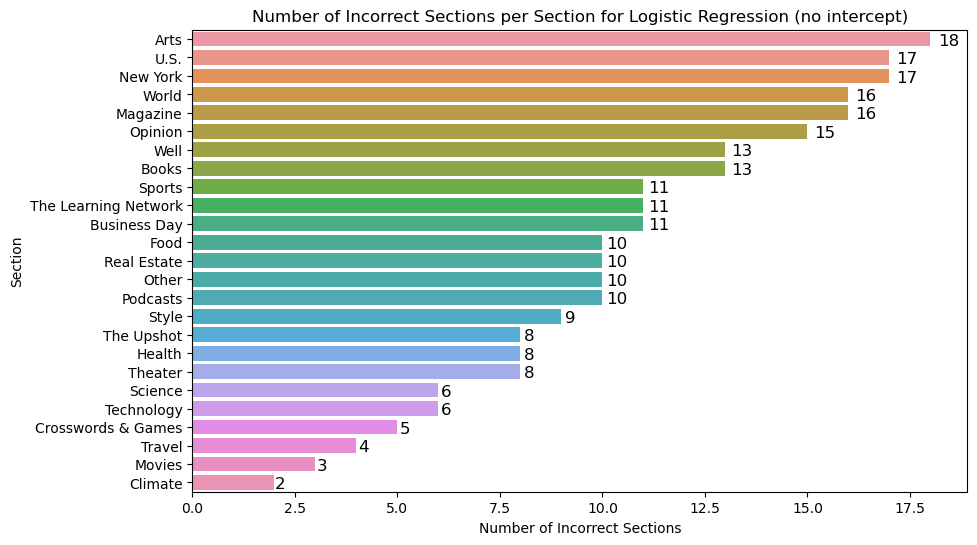

In [59]:
## code from Dr. Jonathan Kropko, University of Virginia School of Data Science; Surfing the Data Pipeline Ch. 11: Visualizations

plt.figure(figsize=(10, 6))
myplot = sns.barplot(x='section_pred_count', y='new_section', data = misclass_groups)
plt.ylabel('Section')
plt.xlabel('Number of Incorrect Sections')
plt.title('Number of Incorrect Sections per Section for Logistic Regression (no intercept)')
for rect in myplot.patches:
    ycoor = rect.get_y() + .6*rect.get_height()
    xcoor = 1.01*rect.get_width()
    plt.text(xcoor, ycoor, str(int(xcoor)), 
             horizontalalignment='left', 
             verticalalignment='center',
             fontsize=12)

plt.show()

plt.close()

#### **Sources**

* Read a CSV file into Spark: https://sparkbyexamples.com/pyspark/pyspark-read-csv-file-into-dataframe/
* Convert columns to different data type with `withColumn` and `df.col1.cast("dtype")`: https://sparkbyexamples.com/pyspark/pyspark-cast-column-type/
* Check for missing values: from `data_preprocessing.ipydt` in `assingments/M4_3_data_preprocs_ungraded`)
* Extract single values from a dataframe in pyspark: https://www.geeksforgeeks.org/pyspark-extracting-single-value-from-dataframe/
* Drop multiple columns with `*`: https://sparkbyexamples.com/pyspark/pyspark-drop-column-from-dataframe/
* Argument `subset` for subset of columns when replacing null values with `df.fillna`: https://sparkbyexamples.com/pyspark/pyspark-fillna-fill-replace-null-values/
* Calculating percentage of total count for groupBy using pyspark: https://stackoverflow.com/questions/52283751/calculating-percentage-of-total-count-for-groupby-using-pyspark
* Spark Dataframe: How to add an index Column with `monotonically_increasing_id`: https://stackoverflow.com/questions/43406887/spark-dataframe-how-to-add-a-index-column-aka-distributed-data-index
* Classification and Regression in Spark: https://spark.apache.org/docs/latest/ml-classification-regression.html
* Multi-Class Text Classification with PySpark $\rightarrow$ for using `CountVectorizer`: https://towardsdatascience.com/multi-class-text-classification-with-pyspark-7d78d022ed35
* `CountVectorizer` documentation: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.CountVectorizer.html#pyspark.ml.feature.CountVectorizer.minDF
* PySpark: modify column values when another column value satisfies a condition with `when` and `otherwise` from `pyspark.sql.functions`: https://stackoverflow.com/questions/43988801/pyspark-modify-column-values-when-another-column-value-satisfies-a-condition
* Get value of a particular cell in PySpark Dataframe: https://www.geeksforgeeks.org/get-value-of-a-particular-cell-in-pyspark-dataframe/
* Using a fraction > 1.0 for up-sampling data: https://stackoverflow.com/questions/53273133/how-to-perform-up-sampling-using-sample-functionpy-spark
* Append data to an empty dataframe in PySpark: https://www.geeksforgeeks.org/append-data-to-an-empty-dataframe-in-pyspark/
* `pyspark.sql.functions.explode` documentation: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.functions.explode.html
* `pyspark.sql.functions.arrays_zip` documentation: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.functions.arrays_zip.html
* Retrieve top n in each group of a DataFrame in pyspark: https://stackoverflow.com/questions/38397796/retrieve-top-n-in-each-group-of-a-dataframe-in-pyspark
* Introducing Window Functions in Spark SQL: https://databricks.com/blog/2015/07/15/introducing-window-functions-in-spark-sql.html
* Convert PySpark DenseVector to array: https://stackoverflow.com/questions/58490770/convert-pyspark-densevector-to-array
* Aggregate function `collect_list`: https://sparkbyexamples.com/pyspark/pyspark-aggregate-functions/
* pyspark `collect_set` or `collect_list` with `groupby`: https://stackoverflow.com/questions/37580782/pyspark-collect-set-or-collect-list-with-groupby
* PySpark Join Types: https://sparkbyexamples.com/pyspark/pyspark-join-explained-with-examples/
* Removing duplicate columns after join in PySpark by specificying duplicate column in join function with argument `['col1']`: https://www.geeksforgeeks.org/removing-duplicate-columns-after-dataframe-join-in-pyspark/#:~:text=Removing%20duplicate%20columns%20after%20join,and%20then%20drop%20duplicate%20columns
* Count categories in another column after `groupby` with `.agg(countDistict('col1'))`: https://stackoverflow.com/questions/46421677/how-to-count-unique-id-after-groupby-in-pyspark
* Checking dataframe equality with `df1.subtract(df2)`: https://community.databricks.com/s/question/0D53f00001HKHZeCAP/comparing-two-dataframes
* Cross validation in pyspark: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.CrossValidator.html?highlight=crossvalidator
* Get (default) metric of `MulticlassMetrics` evaluator with `getMetricName()` method: https://spark.apache.org/docs/1.6.1/api/java/org/apache/spark/ml/evaluation/MulticlassClassificationEvaluator.html
* Increasing driver memory in Jupyter: https://stackoverflow.com/questions/51601478/setting-pyspark-executor-memory-and-executor-core-within-jupyter-notebook
* Getting the best parameter combination from cross validation using `zip` with `.avgMetrics` and `paramGrid`: https://community.databricks.com/s/question/0D53f00001HKHh5CAH/pyspark-how-to-get-best-params-in-grid-search
* Visualizations (bar graphs) code: https://jkropko.github.io/surfing-the-data-pipeline/ch11.html#distributional-graphs
* Nested list comprehensions: https://www.geeksforgeeks.org/nested-list-comprehensions-in-python/
* Remove a legend from a plot in `seaborn`: https://www.delftstack.com/howto/seaborn/remove-legend-seaborn-plot/
* Get the value in a particular row and column in Spark: https://www.geeksforgeeks.org/get-value-of-a-particular-cell-in-pyspark-dataframe/
* `15. ML Model Selection and Tuning.ipynb`
* `11. ML Pipelines.ipynb`
* `10. ML Feature Utilities.ipynb`
* `12. MLlib Regression.ipynb`
* `08. MLlib Statistics.ipynb`
* `09. MLlib Classification.ipynb`
* `07. Machine Learning with MLlib - Overview.ipynb`
* `05. SparkSession, Spark SQL and DataFrames.ipynb`
* `04. Running Spark on a Cluster.ipynb`
* `03. KeyValuePairs.ipynb`
* `02. RDDs.ipynb`
* `01. SparkGettingStarted.ipynb`